In [9]:
# Standard machine learning libraries
import pandas as pd                # dataframe library
import numpy as np                 # math library
import matplotlib.pyplot as plt    # figure plotting
%matplotlib inline

# Classification Model libraries
import pickle
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from collections import Counter
import lightgbm as lgb
import shap

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Data Import
Data has been output from the custom clustering model with labels appended. The raw data was scraped from the [Hiking Project](https://hikingproject.com).

In [2]:
# Import data set into pandas dataframe
df = pd.read_csv("https://raw.githubusercontent.com/KayleighEarly/MachineLearning/main/notebooks/data/labeled_trail_data.csv")

In [3]:
#Display basic data
df

,url,difficulty,dist,type,high_elev,low_elev,elev_gain,elev_lost,grade_avg,grade_max,Cluster Labels
0,https://www.hikingproject.com/trail/7000000/mo...,Intermediate/Difficult,3.2,Loop,6780.0,5521.0,1281.0,1280.0,9.0,23.0,9
1,https://www.hikingproject.com/trail/7000100/lo...,Easy/Intermediate,2.0,Point to Point,5877.0,5504.0,397.0,25.0,2.0,9.0,6
2,https://www.hikingproject.com/trail/7000500/mi...,Intermediate,3.5,Point to Point,11764.0,11092.0,13.0,685.0,2.0,4.0,6
3,https://www.hikingproject.com/trail/7000600/bo...,Intermediate,1.2,Point to Point,6815.0,6631.0,217.0,221.0,4.0,10.0,6
4,https://www.hikingproject.com/trail/7001600/mi...,Intermediate,4.6,Out and Back,5921.0,5482.0,455.0,455.0,2.0,4.0,6
...,...,...,...,...,...,...,...,...,...,...,...
58747,https://www.hikingproject.com/trail/7101599/tw...,Intermediate,1.5,Point to Point,1720.0,1404.0,349.0,89.0,3.0,5.0,11
58748,https://www.hikingproject.com/trail/7101799/sa...,Intermediate/Difficult,0.9,Point to Point,6391.0,5263.0,1131.0,7.0,13.0,21.0,2
58749,https://www.hikingproject.com/trail/7101899/sk...,Intermediate/Difficult,1.4,Point to Point,5504.0,5007.0,15.0,512.0,4.0,11.0,10
58750,https://www.hikingproject.com/trail/7101999/be...,Easy,2.2,Out and Back,13.0,10.0,14.0,13.0,0.0,1.0,1


# Data Features and Preprocessing
The data features represented within the data are as follows:

| Feature | Description |
| :------ | :---------: |
| url | the FQDN the data was scraped from |
| difficulty | the avg reported difficult of the trails |
| dist | the length of the trail (miles) |
| type | the type of trail (loop, point to point, out and back, lollipop) |
| high_elev | the highest elevation reached in the trail (ft) |
| low_elev | the lowest elevation reached in the trail (ft) |
| elev_gain | the total elevation gained across the trail (ft) |
| elev_lost | the total elevation lost across the trail (ft) |
| grade_avg | the average grade of the trail (degrees) |
| grade_max | the maximum grade of the trail (degrees) |
| Cluster Labels | the cluster group the trail belongs to (from 0 to 11) |

Because the data has been previously cleaned, there is minimal preprocessing that needs to be done. First we separate the feature columns from the target column. Then we set the datatype of the two categorical columns (type and difficulty) to category so they are properly handled in training/testing. Last we split the data into training and testing sets with 80% going to training and 20% to testing.

In [4]:
# Identify features columns and target column
X = df.drop(['Cluster Labels','url'], axis=1)
y = df['Cluster Labels']

# Setting the objects to category 
for c in X.select_dtypes(include='object'):
    X[c] = X[c].astype('category')
    
# Split the data, keeping 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(Counter(y_train))
print(Counter(y_test))

(47001, 9) (11751, 9) (47001,) (11751,)
Counter({0: 5758, 11: 5722, 1: 4891, 7: 4623, 6: 4580, 4: 3852, 9: 3442, 8: 3367, 3: 3214, 2: 2970, 5: 2518, 10: 2064})
Counter({0: 1440, 11: 1431, 1: 1223, 7: 1156, 6: 1145, 4: 963, 9: 860, 8: 842, 3: 803, 2: 743, 5: 629, 10: 516})


# Classification Modeling
## Fitting the Model
We use our training data to then define and fit the model.

In [5]:
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

LGBMClassifier()

## Testing the Model

In [6]:
# predict the results
y_pred=clf.predict(X_test)

## Evaluating the Model
### Evaluation via Score Method

In [7]:
# print the default accuracy scores on training and test set
print('Training Set Accuracy: {:.2f}%'.format(clf.score(X_train, y_train) * 100))
print('Test Set Accuracy: {:.2f}%'.format(clf.score(X_test, y_test) * 100))

Training Set Accuracy: 100.00%
Test Set Accuracy: 96.37%


### Evaluation via Scoring Parameter

In [10]:
# print the cross validation accuracy score
print('Cross-Validated Accuracy: {:.2f}%'.format(np.mean(cross_val_score(clf, X, y)) * 100))

Cross-Validated Accuracy: 96.77%


### Area under the reciever operating characteristic curve (AUC/ROC)
While ROC AUC scores are typically used in binary classification problems, they can be used for multi-class sitations as well.

In [11]:
# fit model
y_prob = clf.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.999645 (macro),
0.999641 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.999656 (macro),
0.999636 (weighted by prevalence)


### Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

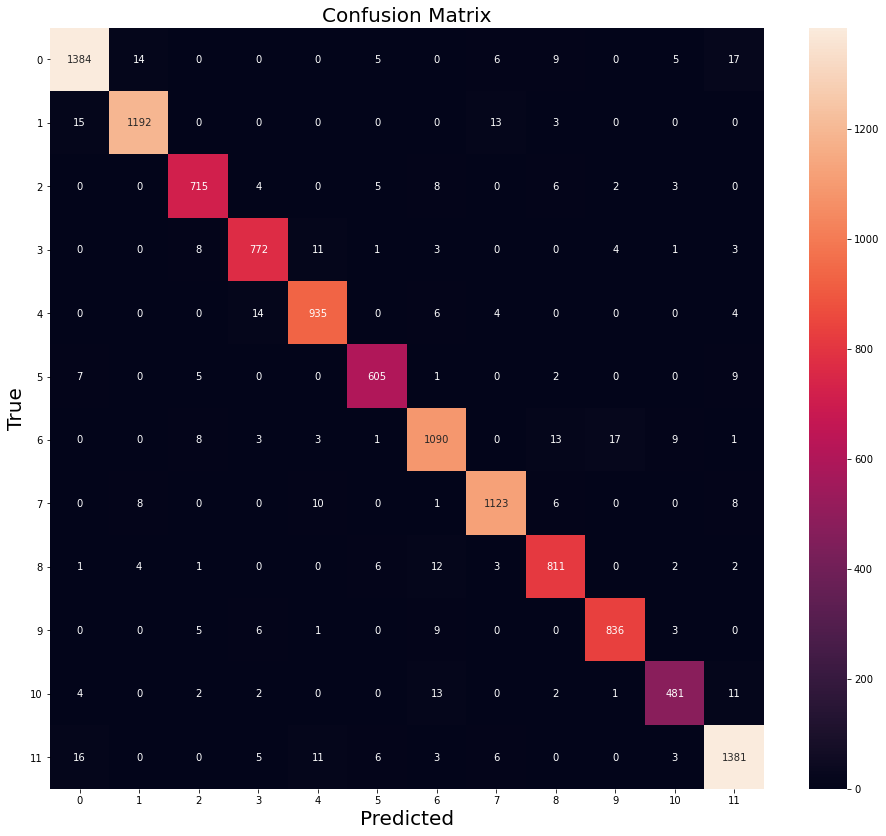

In [12]:
### Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g')

# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
ax.xaxis.tick_bottom()
ax.set_ylabel('True', fontsize=20)
plt.yticks(rotation=0)

plt.title('Confusion Matrix', fontsize=20)

### Classification Report

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1440
           1       0.98      0.97      0.98      1223
           2       0.96      0.96      0.96       743
           3       0.96      0.96      0.96       803
           4       0.96      0.97      0.97       963
           5       0.96      0.96      0.96       629
           6       0.95      0.95      0.95      1145
           7       0.97      0.97      0.97      1156
           8       0.95      0.96      0.96       842
           9       0.97      0.97      0.97       860
          10       0.95      0.93      0.94       516
          11       0.96      0.97      0.96      1431

    accuracy                           0.96     11751
   macro avg       0.96      0.96      0.96     11751
weighted avg       0.96      0.96      0.96     11751



### Feature Impact on Model
As shown in the bar graph below, of the 9 features, 8 had an impact on the classification prediction, with 7 of them having a high impact. This means that the clusters are both distinguishable and informed by the majority of input.

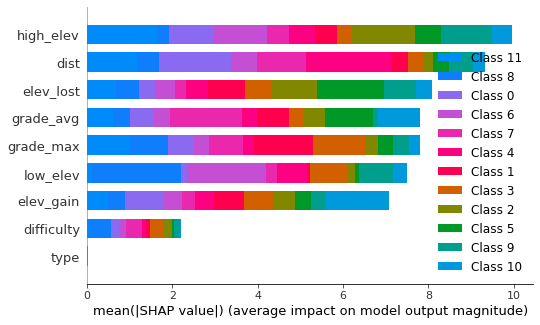

In [14]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)

## Saving Trained Model for Later Use

In [15]:
pickle.dump(clf, open("models\gbm_model_1.pkl", "wb"))